In [1]:
import cufflinks as cf
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from ta import add_all_ta_features
from ta.utils import dropna
from _lumber_prices import get_lumber_db_xl

# FETCH Data

In [2]:
def add_technical_indicators(TA_df):

    TA_df.columns = ['Open','High','Low','Close','Volume','OpenInterest']
    TA_df = dropna(TA_df)
    TA_df.sort_index(ascending=True, inplace=True)
    TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
    TA_df.sort_index(ascending=False, inplace=True)
    TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
    TA_df.columns = [('TA_',x) for x in TA_df.columns]
    TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
    return TA_df

# This func combines all trading dates from Barchart (historical) and cwp live lumber trading dates
def lumber_trading_days():
    barchart_idx = pd.DatetimeIndex(pd.DataFrame(pd.read_csv('F:/Traders/2x4/Adjusted CME Futures/Switch_OI/Lumber.csv',index_col=0)).index)
    cwp_idx = get_lumber_db_xl()[1].index
    cwp_idx = cwp_idx[cwp_idx>barchart_idx[0]]
    return cwp_idx.append(barchart_idx).sort_values(ascending=False)


file_path = 'C:/source/2x4-data/app/model_building/daily_dataframe_main.xlsx'
### Reading Data from Excel daily_dataframe_main - Takes 1 min 40 secs to run
Variables = pd.read_excel(file_path, header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel(file_path,sheet_name= 'Response' ,index_col=0)
TA_df = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
TA_df = add_technical_indicators(TA_df)
TA_df.replace([np.inf, -np.inf], np.nan, inplace=True)
TA_df.fillna(method='bfill', inplace=True)

Variables.sort_index(ascending = False, inplace = True)
Response.sort_index(ascending = False, inplace = True)

cme = mcal.get_calendar("CME_Agriculture")
cme_trading_days = cme.schedule(start_date=Variables.index[-1].date(), end_date=Variables.index[0].date()).index
cme_trading_days = cme_trading_days.sort_values(ascending=False)
cme_trading_days = pd.DatetimeIndex(cme_trading_days)

trading_days = lumber_trading_days()
# Variables = Variables[Variables.index > '2012-01-01']
Variables = Variables[Variables.index.isin(cme_trading_days)]
Variables = Variables[Variables.index.isin(trading_days)]

# Response = Response[Response.index > '2012-01-01']
Response = Response[Response.index.isin(cme_trading_days)]
Response = Response[Response.index.isin(trading_days)]
# Response = Response[(Response.Close_Up_Down == 1) | (Response.Close_Up_Down == -1)]

Variables.index = pd.DatetimeIndex(Variables.index)
Response.index = pd.DatetimeIndex(Response.index)
Variables = Variables.reindex(Response.index)

Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1, inplace=True)
Variables.drop(Variables.columns[Variables.isnull().all()].to_list(), axis=1, inplace=True)

Response.drop(Response.columns[Response.isna().all()].to_list(), axis=1, inplace=True)
Response.drop(Response.columns[Response.isnull().all()].to_list(), axis=1, inplace=True)

Getting data from CWP database & excel files::  33%|███▎      | 1/3 [00:04<00:09,  4.66s/it]

Time Taken for Contract:1 00:04


Getting data from CWP database & excel files::  67%|██████▋   | 2/3 [00:08<00:04,  4.05s/it]

Time Taken for Contract:2 00:08


Getting data from CWP database & excel files:: 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]

Time Taken for Contract:3 00:13


# CUFF

In [8]:
Lumber_OHLCVI = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
Lumber_OHLCVI.columns = ['Open','High','Low','Close','Volume','OpenInterest']
Lumber_OHLCVI

,Open,High,Low,Close,Volume,OpenInterest
2022-08-15,595.599976,611.400024,583.799988,588.700012,219.0,1569.0
2022-08-12,601.799988,635.599976,577.099976,595.599976,647.0,1654.0
2022-08-11,552.799988,601.799988,573.000000,601.799988,487.0,1808.0
2022-08-10,519.299988,565.000000,528.400024,552.799988,376.0,1895.0
2022-08-09,479.200012,528.200012,483.200012,519.299988,398.0,1946.0
...,...,...,...,...,...,...
2012-01-09,111.169842,115.372442,112.364265,112.762406,568.0,5773.0
2012-01-06,108.073189,115.372442,112.806644,114.753111,382.0,5528.0
2012-01-05,111.037128,116.655341,112.364265,112.629692,462.0,5569.0
2012-01-04,109.311850,118.778760,115.726345,116.478390,898.0,5587.0


In [9]:
cf.set_config_file(offline=True)

In [10]:
Lumber_OHLCVI.Close.iplot()

In [21]:
from textwrap import fill


Lumber_OHLCVI[['Open','High','Low','Close']].iplot(fill=True, title='Lumber OHLC', xTitle='Date', yTitle='Price', theme = 'ggplot')

In [27]:
Lumber_OHLCVI[['High','Low']].iplot(kind = 'spread', colorscale ="rdylbu", fill=True, title='Lumber High Low', xTitle='Date', yTitle='Price', theme = 'white')

In [16]:
# cf.colors.scales()
cf.getThemes()

['ggplot', 'pearl', 'solar', 'space', 'white', 'polar', 'henanigans']

In [28]:
Lumber_OHLCVI[['Open','High','Low','Close']].iplot(kind = 'candle')

In [29]:
Lumber_OHLCVI[['Open','High','Low','Close']].iplot(kind = 'ohlc')

In [39]:
Lumber_OHLCVI.resample("W-Fri").ohlc()

Open                                            High  \
                  open        high         low       close        open   
2012-01-06  109.311850  111.037128  108.073189  108.073189  117.805527   
2012-01-13  111.169842  111.169842  109.090660  109.090660  115.372442   
2012-01-20  110.771700  110.771700  107.055717  107.453858  112.673930   
2012-01-27  106.701814  106.701814  104.091778  105.595866  106.834527   
2012-02-03  106.569100  112.364265  105.065011  112.364265  108.161664   
...                ...         ...         ...         ...         ...   
2022-07-22  640.000000  682.000000  631.599976  631.599976  650.000000   
2022-07-29  623.200012  623.200012  555.200012  555.200012  617.000000   
2022-08-05  536.700012  536.700012  493.200012  493.200012  535.099976   
2022-08-12  500.000000  601.799988  479.200012  601.799988  518.500000   
2022-08-19  595.599976  595.599976  595.599976  595.599976  611.400024   

                                                       Low              ...  \
                  high         low       close        open        high  ...   
2012-01-06  118.778760  115.372442  115.372442  114.753111  115.726345  ...   
2012-01-13  115.372442  108.825233  108.825233  112.364265  112.364265  ...   
2012-01-20  112.673930  108.338616  108.338616  110.196608  110.196608  ...   
2012-01-27  109.267612  106.392148  107.896237  104.224491  106.436386  ...   
2012-02-03  114.089543  107.763523  113.381737  104.843822  110.815938  ...   
...                ...         ...         ...         ...         ...  ...   
2022-07-22  650.000000  630.000000  630.000000  618.099976  628.200012  ...   
2022-07-29  617.000000  559.200012  559.200012  576.200012  576.200012  ...   
2022-08-05  545.200012  502.000000  502.000000  523.099976  523.099976  ...   
2022-08-12  635.599976  518.500000  635.599976  473.600006  577.099976  ...   
2022-08-19  611.400024  611.400024  611.400024  583.799988  583.799988  ...   

                 Close              Volume                         \
                   low       close    open    high    low   close   
2012-01-06  112.629692  114.753111   478.0   898.0  382.0   382.0   
2012-01-13  104.534157  104.534157   568.0  1361.0  326.0  1053.0   
2012-01-20  106.701814  106.701814   365.0   627.0  334.0   422.0   
2012-01-27  104.091778  106.569100   466.0   665.0  341.0   665.0   
2012-02-03  105.065011  111.833410  1252.0  1895.0  736.0   954.0   
...                ...         ...     ...     ...    ...     ...   
2022-07-22  623.200012  623.200012    15.0   243.0   15.0   243.0   
2022-07-29  536.700012  536.700012   256.0   374.0  201.0   371.0   
2022-08-05  493.200012  500.000000   307.0   372.0  227.0   372.0   
2022-08-12  479.200012  595.599976   282.0   647.0  282.0   647.0   
2022-08-19  588.700012  588.700012   219.0   219.0  219.0   219.0   

           OpenInterest                          
                   open    high     low   close  
2012-01-06       5167.0  5587.0  5167.0  5528.0  
2012-01-13       5773.0  6253.0  5773.0  6215.0  
2012-01-20       6161.0  6456.0  6161.0  6456.0  
2012-01-27       6506.0  6785.0  6506.0  6785.0  
2012-02-03       6347.0  6347.0  5347.0  5347.0  
...                 ...     ...     ...     ...  
2022-07-22        362.0  1439.0   362.0  1379.0  
2022-07-29       1354.0  1555.0  1354.0  1555.0  
2022-08-05       1603.0  1865.0  1603.0  1865.0  
2022-08-12       1939.0  1946.0  1654.0  1654.0  
2022-08-19       1569.0  1569.0  1569.0  1569.0  

[555 rows x 24 columns]

In [41]:
Lumber_OHLCVI.resample("W-Fri").agg({'Open':'first','High':'max','Low':'min','Close':'last'})

,Open,High,Low,Close
2012-01-06,109.311850,118.778760,112.364265,114.753111
2012-01-13,111.169842,115.372442,103.251258,104.534157
2012-01-20,110.771700,112.673930,104.401443,106.701814
2012-01-27,106.701814,109.267612,103.782112,106.569100
2012-02-03,106.569100,114.089543,104.843822,111.833410
...,...,...,...,...
2022-07-22,640.000000,650.000000,599.400024,623.200012
2022-07-29,623.200012,617.000000,531.000000,536.700012
2022-08-05,536.700012,545.200012,470.600006,500.000000
2022-08-12,500.000000,635.599976,473.600006,595.599976


# Volume Charts

In [50]:
Lumber_OHLCVI.iloc[:,:-1]

,Open,High,Low,Close,Volume
2022-08-15,595.599976,611.400024,583.799988,588.700012,219.0
2022-08-12,601.799988,635.599976,577.099976,595.599976,647.0
2022-08-11,552.799988,601.799988,573.000000,601.799988,487.0
2022-08-10,519.299988,565.000000,528.400024,552.799988,376.0
2022-08-09,479.200012,528.200012,483.200012,519.299988,398.0
...,...,...,...,...,...
2012-01-09,111.169842,115.372442,112.364265,112.762406,568.0
2012-01-06,108.073189,115.372442,112.806644,114.753111,382.0
2012-01-05,111.037128,116.655341,112.364265,112.629692,462.0
2012-01-04,109.311850,118.778760,115.726345,116.478390,898.0


In [85]:
Lumber_OHLCVI.sort_index(ascending=True, inplace=True)

In [115]:
qf = cf.QuantFig(df = Lumber_OHLCVI.sort_index(ascending=True).iloc[:,:-1].loc["2021":"2022"])
qf.add_volume(colorchange=False)
qf.add_sma(periods=30, color='red', linewidth=2)
# qf.add_sma(periods=200, color='green', linewidth=2)
# qf.add_bollinger_bands(periods=30, boll_std = 2)

qf.add_macd()
qf.add_dmi()

qf.iplot()

In [138]:
qf = cf.QuantFig(df = Lumber_OHLCVI.sort_index(ascending=True).iloc[:,:-1].loc["2021":"2022"])
qf.add_trendline(date0='2022-07-14', date1='2022-08-15')
qf.iplot()

In [148]:
qf = cf.QuantFig(df = Lumber_OHLCVI.sort_index(ascending=True).iloc[:,:-1].loc["2020":"2022"])
qf.add_resistance(date='2022-07-11')
qf.iplot()

# MPLFINANCE

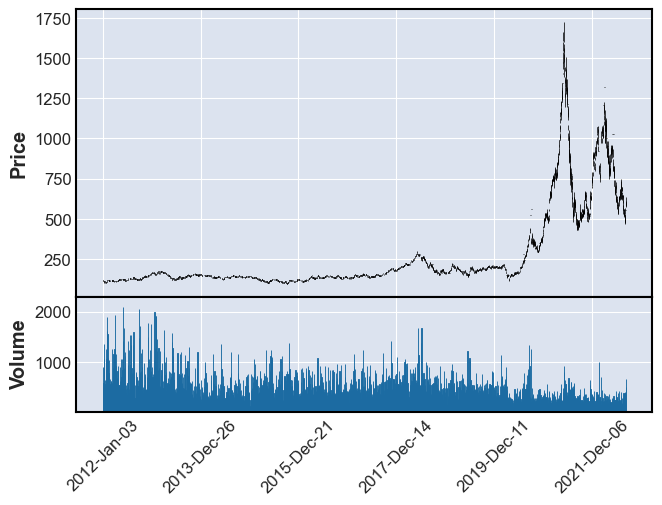

In [34]:
import mplfinance as mpf
mpf.plot(Lumber_OHLCVI.sort_index(),volume=True)